<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Import-Packages-&amp;-Data" data-toc-modified-id="Import-Packages-&amp;-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Packages &amp; Data</a></span></li><li><span><a href="#Clean-&amp;-Explore-Data" data-toc-modified-id="Clean-&amp;-Explore-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean &amp; Explore Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Build-&amp;-Fit-Baseline-Model" data-toc-modified-id="Build-&amp;-Fit-Baseline-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Build &amp; Fit Baseline Model</a></span></li><li><span><a href="#Forecasting-&amp;-Predictions" data-toc-modified-id="Forecasting-&amp;-Predictions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Forecasting &amp; Predictions</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Recommendations" data-toc-modified-id="Recommendations-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Recommendations</a></span></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Future Work</a></span></li></ul></li></ul></div>

# Intro

# Import Packages & Data

In [4]:
# Import Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from fbprophet import Prophet

In [6]:
# Import Data

data = pd.read_csv('Historical_Product_Demand.csv')
df = pd.DataFrame(data)

In [7]:
# Preview Data

df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Clean & Explore Data

Since we're fitting time series models, we're going to want to change the Date column to be in datetime format and set it as the index. We'll explore a bit first before getting to that. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 5 columns):
Product_Code        999999 non-null object
Warehouse           999999 non-null object
Product_Category    999999 non-null object
Date                988760 non-null object
Order_Demand        999999 non-null int64
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


We can see the 'Date' column has fewer values than the rest of the columns, which indicates missing data. It doesn't look like much of the data are missing, so if they're indeed null, then we can go ahead and drop those rows.

We can also see that basically every category other than 'Order_Demand' are objects. That's totally fine as we will use them to categorize, however our time series will simply be date and demand.

Let's take a look at our summary statistics for order demand.

In [17]:
# Summary statistics
df.describe().round()

,Order_Demand
count,999999.0
mean,5071.0
std,29603.0
min,-999000.0
25%,20.0
50%,300.0
75%,2000.0
max,4000000.0


With a minimum of -999000.0, it looks like this may be a null value, so we can search for those nulls as well.

Let's go ahead and get those rows with null date values removed, and then change our date column into datetime format and rather than set to index actually, we will set it to Facebook Profit's special 'ds' column.

In [18]:
df[df.Order_Demand == -999000]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
585144,Product_1241,Whse_J,Category_019,2014/3/27,-999000


In [19]:
df.isnull().any()

Product_Code        False
Warehouse           False
Product_Category    False
Date                 True
Order_Demand        False
dtype: bool

In [21]:
df[df.Date.isnull() == True]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
45460,Product_1461,Whse_A,Category_019,NaN,10000
456373,Product_1636,Whse_A,Category_019,NaN,100
456374,Product_1461,Whse_A,Category_019,NaN,300
456375,Product_1464,Whse_A,Category_019,NaN,300
456376,Product_1388,Whse_A,Category_019,NaN,200
...,...,...,...,...,...
995790,Product_1464,Whse_A,Category_019,NaN,-900
995791,Product_1541,Whse_A,Category_019,NaN,-200
995792,Product_1388,Whse_A,Category_019,NaN,-300
995793,Product_1541,Whse_A,Category_019,NaN,-300


This looks like a lot of rows, and that they're all from Warehouse A. Some of them appear to have negative demand as well. Let's take a closer look. 

In [22]:
whse_a = df[df.Warehouse == 'Whse_A']
whse_a

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
34593,Product_0905,Whse_A,Category_023,2012/3/7,50
41029,Product_0097,Whse_A,Category_019,2012/1/18,6000
41030,Product_1496,Whse_A,Category_019,2012/3/13,5000
41031,Product_0097,Whse_A,Category_019,2012/4/16,6000
41032,Product_0097,Whse_A,Category_019,2012/9/24,3900
...,...,...,...,...,...
995797,Product_1822,Whse_A,Category_018,2016/3/1,2
995798,Product_1470,Whse_A,Category_019,2016/5/19,100
995799,Product_0599,Whse_A,Category_017,2016/9/15,12
995800,Product_0599,Whse_A,Category_017,2016/10/26,10


We can see that 11240/153574 of the values are null. There's really no other way to interpolate time data for a warehouse with a NaN value for date, so we're going to remove it. 

We can also check to see how many rows we have for the other warehouses for comparison. 

In [24]:
df.Warehouse.value_counts()

Whse_J    715944
Whse_A    153574
Whse_S     88127
Whse_C     42354
Name: Warehouse, dtype: int64

We can see that Warehouse A is the second largest warehouse. There is a decent amount of variance among the warehouses, so it doesn't seem to be much of an issue to remove the rows.

Let's drop the null values.

In [26]:
# Drop rows with NaN values (which were only in Date column)
df = df.dropna()

In [27]:
# Get index of row with large negative order demand 
df[df.Order_Demand == -999000]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
585144,Product_1241,Whse_J,Category_019,2014/3/27,-999000


In [29]:
# Drop row 
df = df.drop(index=585144)

Now we'll set the Date column to datetime format.

In [31]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988759 entries, 0 to 999998
Data columns (total 5 columns):
Product_Code        988759 non-null object
Warehouse           988759 non-null object
Product_Category    988759 non-null object
Date                988759 non-null datetime64[ns]
Order_Demand        988759 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 45.3+ MB


Great! Now our Date column is set to datetime format so we can subset our data as needed and create time series from it. Now, to the visual exploration (EDA)!

# EDA 

Let's take a look at product demand for the entire time series. Note: I zoomed in on the x-axis as 2011 data was significantly lower. We'll take a closer look at 2011 following this plot.

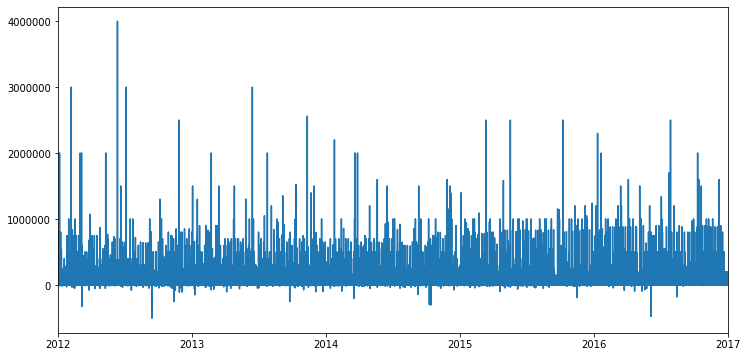

In [55]:
# Plot demand data for entire dataset

# Import datetime to set x-axis limits
import datetime

# Sort by date first for plotting
df = df.sort_values('Date')

# Set x & y
x = df.Date
y = df.Order_Demand

# Plot
plt.figure(figsize=(12,6))
plt.plot(x, y)

# Set x-axis limits (low demand data for 2011 - may be able to remove this year)
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2017, 1, 1)]);

We can see a really big spike mid 2012. I wonder why? Perhaps there was a promotion or a new product launch or something similar? The demand seems pretty consistent through out the years with a slight drop in Q3 of 2014. 

Let's get a closer look at 2011 (not pictured here as I intentionally zoomed in on the axis for a better visual of the data). 

In [86]:
# Create a time series

# Set index to datetime column 
ts_df = df.set_index('Date')
# Select extra columns to drop (everything except 'Order_Demand')
to_drop = ['Product_Code','Warehouse','Product_Category']
# Drop columns
ts = ts_df.drop(to_drop, axis=1)

In [87]:
# Groupby year
ts_yr = ts.groupby(by=ts.index.year).sum()
ts_yr

,Order_Demand
Date,
2011,7509986
2012,941742907
2013,1009218798
2014,1065271479
2015,1095426177
2016,952219589
2017,294701


We can see that  2011 and 2017 are significantly lower. Let's find out why. First, we'll make a visual. 

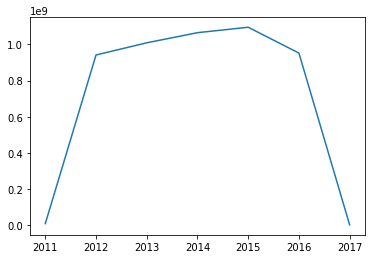

In [88]:
plt.plot(ts_yr.index, ts_yr.Order_Demand);

We again can see that demand was significantly lower in 2011 and 2017. I imagine these are either incomplete years or that 2011 was just the beginning, so it took time to gain momentum or perhaps not all of the warehouses were open yet. 

Let's take a closer look to be sure.

In [89]:
# Index time series by year 2011
ts['2011']

,Order_Demand
Date,
2011-01-08,2
2011-05-31,108
2011-06-24,7000
2011-06-24,85000
2011-09-02,1250
...,...
2011-12-30,224
2011-12-30,30
2011-12-30,230


We can see that for 2011 we do have all dates/the entire year present. This may indicate the beginning/when the warehouse(s) were brand new or just starting out. Now let's take a look at 2017.

In [90]:
# Index time series by year 2017
ts['2017']

,Order_Demand
Date,
2017-01-02,70
2017-01-03,200
2017-01-03,2000
2017-01-03,200
2017-01-04,10000
2017-01-04,1000
2017-01-04,3000
2017-01-04,1000
2017-01-04,1000


We can see that for this year the data only go through to January 9th, so this is an incomplete year. 

For the sake of our modeling, we will remove 2011 from the data. Again let's visualize that here.

In [91]:
ts_yr

,Order_Demand
Date,
2011,7509986
2012,941742907
2013,1009218798
2014,1065271479
2015,1095426177
2016,952219589
2017,294701


We can see that for those years with data for every day, which are years 2012-2016, the order demand is pretty consistent, with 2012 and 2016 being only slightly lower, and 2017 representing only 9 days of the year. 

So let's go ahead and drop 2011 from our dataset.

In [101]:
ts_df = ts_df['2012':]
ts_df

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-01,Product_2166,Whse_S,Category_024,2
2012-01-02,Product_1433,Whse_S,Category_019,2000
2012-01-02,Product_1343,Whse_S,Category_019,5000
2012-01-02,Product_2004,Whse_S,Category_005,2000
2012-01-02,Product_1291,Whse_A,Category_019,500
...,...,...,...,...
2017-01-06,Product_1359,Whse_J,Category_019,100000
2017-01-06,Product_1926,Whse_J,Category_001,2
2017-01-09,Product_0250,Whse_C,Category_007,148


Looks great! Now we can get to building our baseline model and predicting overall demand. This should be pretty easy to do as we can already see there seems to be an overall consistent amount of demand year over year with all warehouses combined.

As we move further along we can group by warehouse, and depending how many products there are, we can group by product as well. We already know which warehouses are most productive, as we saw early on when we were cleaning and exploring our data.

Let's go ahead and take a look again.

In [103]:
ts_df.Warehouse.value_counts()

Whse_J    715750
Whse_A    142197
Whse_S     87953
Whse_C     42219
Name: Warehouse, dtype: int64

We can see the order here of the most productive warehouses, with J and A in the lead. J by a landslide. S and C being much lower in production. Possibly smaller and servicing more satelite regions. 

Let's take a look at the same, but for products. 

In [104]:
ts_df.Product_Code.value_counts()

Product_1359    16786
Product_1295    10406
Product_1378     9574
Product_0620     8948
Product_1286     8792
                ...  
Product_0465        1
Product_0244        1
Product_0234        1
Product_0233        1
Product_2099        1
Name: Product_Code, Length: 2157, dtype: int64

Right away we can see there are some products at the bottom that only have 1 entry. My first thought is that these products should be eliminated. However, they could have been newly introduced in January of 2017 and thus would not have a long record and/or they could have high order numbers and perhaps represent a custom order. Let's take a closer look.

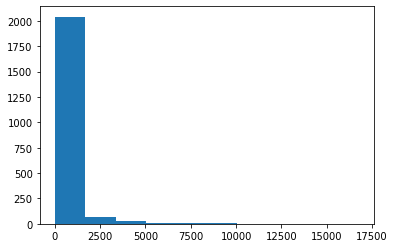

In [106]:
plt.hist(ts_df.Product_Code.value_counts());

Again my intuition in looking at this histogram is that it would be wise to focus only on the highest demand products and cut the rest. I will go into more detail later on how this will save time/money/floorspace as well as improve/increase efficiency. 

In [167]:
# Let's look at lifetime demand of each product

ts_df_prod = ts_df.groupby(by=ts_df.Product_Code).sum()
ts_df_prod = ts_df_prod.sort_values(by='Order_Demand')
ts_df_prod

,Order_Demand
Product_Code,
Product_1698,2
Product_1703,2
Product_0465,3
Product_2151,5
Product_0466,15
...,...
Product_1295,121852300
Product_1341,166411000
Product_0083,210303000


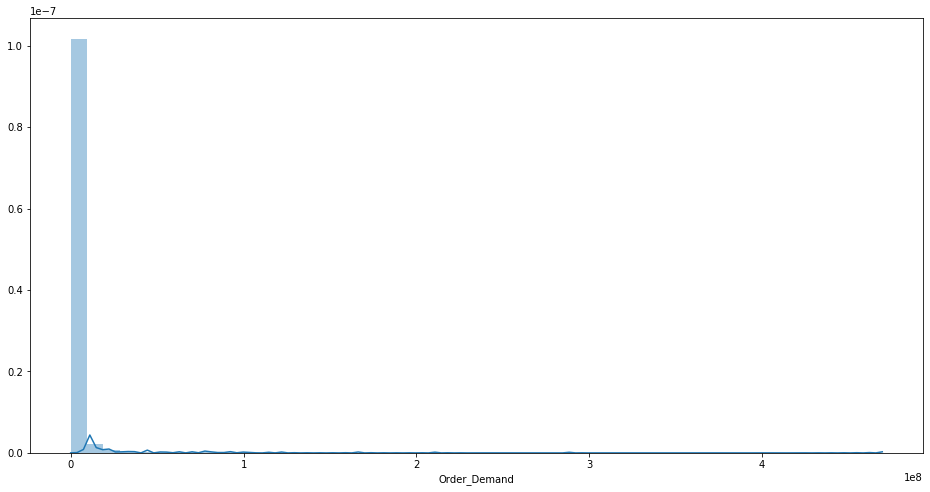

In [177]:
ts_df_prod = ts_df_prod.sort_values(by='Order_Demand', ascending=False)
import seaborn as sns
plt.figure(figsize=(16,8))
sns.distplot(ts_df_prod.Order_Demand);

We can see here visually that a small percentage of available products make up a very large proportion of orders. If we had more detailed information such as profits from each product, we could do a more detailed analysis here to make suggestions on which products to cut from which warehouses.

In an even more detailed analysis it would be good to know footprint of the warehouse as well as number of employees and cost of employees so we could see where things could be culled down and streamlined. How much money can be saved and profits increased. 

If warehouses were to focus on fewer products which make up the greatest amount of orders/profit, could they then hold more stock of the most popular product and increase demand in other ways, such as advertising and saving money on larger purchase orders/more stock/inventory held? 

I will also discuss this in future work. 

In [153]:
ts_df_prod[ts_df_prod.Order_Demand <= 50]

,Order_Demand
Product_Code,
Product_1698,2
Product_1703,2
Product_0465,3
Product_2151,5
Product_0466,15
Product_1863,18
Product_0647,19
Product_0244,20
Product_0633,21


In [139]:
ts_df[ts_df.Product_Code == 'Product_1698']

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-10-12,Product_1698,Whse_A,Category_021,1
2016-08-29,Product_1698,Whse_A,Category_021,1


In [142]:
ts_df[ts_df.Product_Code == 'Product_1703']

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2015-10-08,Product_1703,Whse_A,Category_021,2


In [141]:
ts_df[ts_df.Product_Code == 'Product_0465']

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2016-08-02,Product_0465,Whse_A,Category_012,3


# Modeling 

## Build & Fit Baseline Model

## Forecasting & Predictions

## Discussion

# Conclusion

## Results

## Recommendations

## Future Work